[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

In [1]:
import sys
!{sys.executable} git+https://github.com/huggingface/transformers -q
!{sys.executable} -m pip install transformers -q
!{sys.executable} -m pip install accelerate -q
# !{sys.executable} -m pip install flash-attn --no-build-isolation -q
!{sys.executable} -m pip install datasets -q


/usr/bin/python3: can't open file '/content/git+https://github.com/huggingface/transformers': [Errno 2] No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for flash-attn
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (flash-attn)


In [4]:
!nvidia-smi

Sun Nov 30 16:54:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Loading of the model

In [5]:
import torch
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

model_id = "Qwen/Qwen3-VL-2B-Instruct"

model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_id,
    dtype=torch.bfloat16,
    device_map="cuda",   # или "auto"
)

processor = AutoProcessor.from_pretrained(model_id)

torch.cuda.is_available(), torch.cuda.get_device_name(0)



generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

(True, 'Tesla T4')

#Loading of the dataset

In [6]:
from datasets import load_dataset

ds_dict = load_dataset("Mozilla/flickr30k-transformed-captions-gpt4o")
ds = ds_dict["test"]   # единственный сплит

test_ds = ds.filter(lambda example: example["split"] == "test")
train_ds = ds.filter(lambda example: example["split"] == "train")

README.md: 0.00B [00:00, ?B/s]

data/test-00000-of-00003.parquet:   0%|          | 0.00/405M [00:00<?, ?B/s]

data/test-00001-of-00003.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

data/test-00002-of-00003.parquet:   0%|          | 0.00/412M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

#Function for the model inference

In [7]:
def caption_with_qwen(example):
    test_example_image = example["image"]

    messages = [
            {
                "role": "user",
                "content": [{"type": "text", "text": "Describe this image."}],
            }
        ]

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False,
            # temperature=0.0,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]

    return {"baseline_answ": output_text.strip()}


#Check function

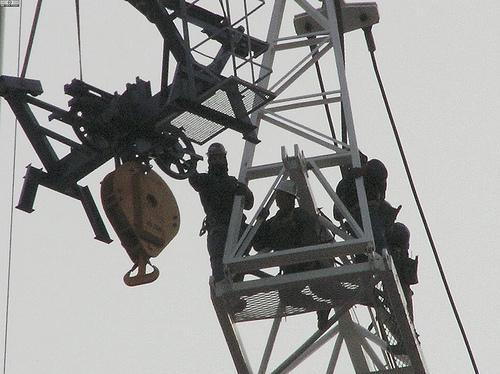

In [10]:
test_example = ds[1]
test_example['image']

In [12]:
model_answer = caption_with_qwen(test_example)
model_answer['baseline_answ']

"This image shows a close-up of a person's hand, specifically the palm and fingers, with a focus on the skin and the natural texture of the hand. The hand is positioned in a way that the palm is facing the viewer, and the fingers are slightly curled. The skin appears smooth with a natural, light-to"

#Launch inference for the test dataset

In [ ]:
from tqdm.auto import tqdm

# прогресс-бар для map
tqdm.pandas()

ds_with_baseline = test_ds.map(
    caption_with_qwen,
    desc="Running Qwen3-VL on test split",
)
ds_with_baseline


Running Qwen3-VL on test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text', 'objects', 'baseline_answ'],
    num_rows: 1000
})